# Pengujian dengan Arsitektur referensi dari Paper COVFake


In [ ]:
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Class

### Evaluation Metrics
- Recall
- Precision
- F1 Measure

In [ ]:
from keras import backend as K

class evaluation_metrics:
    def recall_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(y_true, y_pred):
        precision = evaluation_metrics.precision_m(y_true, y_pred)
        recall = evaluation_metrics.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Build Model

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import model_from_json
import os

class Model():

    def __init__(self, lstm_neuron, dense_neuron, learning_rate, epoch, batch_size, arsitektur=2):
        self.n_lstm = lstm_neuron
        self.n_dense = dense_neuron
        self.n_lr = learning_rate
        self.n_epoch = epoch
        self.n_batchsize = batch_size
        self.arsitektur = arsitektur
        self.model = Sequential()

    def lstm(self, word_index, embedding_matrix, shape):
        embedding_shape = len(embedding_matrix[0])
        self.model.add(Input(shape=(shape,)))
        self.model.add(Embedding(len(word_index)+1,
                            embedding_shape,
                            weights = [embedding_matrix],
                            input_length = shape,
                            trainable = False))
        self.model.add(LSTM(self.n_lstm))
        if self.arsitektur == 4:
            self.model.add(Dense(self.n_dense, activation='relu'))
        self.model.add(Dense(1, activation='sigmoid'))

    def gru(self, word_index, embedding_matrix, shape):
        embedding_shape = len(embedding_matrix[0])
        self.model.add(Input(shape=(shape,)))
        self.model.add(Embedding(len(word_index)+1,
                            embedding_shape,
                            weights = [embedding_matrix],
                            input_length = shape,
                            trainable = False))
        self.model.add(GRU(self.n_lstm))
        if self.arsitektur == 2:
            self.model.add(Dense(self.n_dense, activation='relu'))
        self.model.add(Dense(1, activation='sigmoid'))

    def summary(self):
        self.model.summary()

    def doTrain(self, X_train, y_train, X_val, y_val):
        print("Epoch set to              : ", self.n_epoch)
        print("Adam Learning Rate set to : ", self.n_lr)
        if self.arsitektur == 3 or self.arsitektur == 4:
            print("GRU neuron set to        : ", self.n_lstm)
        else:
            print("LSTM neuron set to        : ", self.n_lstm)

        if self.arsitektur == 2 or self.arsitektur == 4:
            print("NN neuron set to          : ", self.n_dense)
 
        opt = Adam(learning_rate=self.n_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        self.model.compile(loss="binary_crossentropy",
                           optimizer=opt,
                           metrics=['accuracy', evaluation_metrics.recall_m, evaluation_metrics.precision_m, evaluation_metrics.f1_m])
        history = self.model.fit(X_train, y_train, epochs=self.n_epoch, batch_size=self.n_batchsize, validation_data=(X_val, y_val))

        return history, self.model
    
    def lossSummary(self, history):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss)+1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def accSummary(self, history):
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        loss = history.history['loss']
        epochs = range(1, len(loss)+1)
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
    def modelTrainEvaluation(self, history):
        accuracy = history.history['accuracy']
        precision = history.history['precision_m']
        recall = history.history['recall_m']
        f1_measure = history.history['f1_m']
        loss = history.history['loss']
        epochs = range(1, len(loss)+1)
        plt.plot(epochs, accuracy, label='Model accuracy')
        plt.plot(epochs, precision, label='Precision')
        plt.plot(epochs, recall, label='Recall')
        plt.plot(epochs, f1_measure, label='F1 Measure')
        plt.title('Train Model Evaluation')
        plt.ylabel('Ratio')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

    def modelValEvaluation(self, history):
        accuracy = history.history['val_accuracy']
        precision = history.history['val_precision_m']
        recall = history.history['val_recall_m']
        f1_measure = history.history['val_f1_m']
        loss = history.history['val_loss']
        epochs = range(1, len(loss)+1)
        plt.plot(epochs, accuracy, label='Model accuracy')
        plt.plot(epochs, precision, label='Precision')
        plt.plot(epochs, recall, label='Recall')
        plt.plot(epochs, f1_measure, label='F1 Measure')
        plt.title('Val Model Evaluation')
        plt.ylabel('Ratio')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()


    def doPredict(self, X_test, y_test):
        print("------------------EVALUATE MODEL--------------------")
        self.model.evaluate(x_test, y_test)
        print("----------------------------------------------------")
        predicted = self.model.predict(X_test)
        rounded_result = [int(round(x[0])) for x in predicted]

        cm = confusion_matrix(y_test, rounded_result)

        (tn, fp,
        fn, tp) = cm.flatten()

        plt.figure(figsize = (5, 5))
        sns.heatmap(cm, annot = True, fmt=".0f", cmap='Blues')

        # precision = tp/(fp+tp) * 100
        # recall = tp/(fn+tp) * 100
        # f1 = 2*((precision * recall) / (precision + recall))
        # accuracy = ((tn + tp)/ (tn + fn + tp + fp)) * 100

        ###
        # print('--------- Test Evaluation ---------')
        # print('Accuracy  : ', accuracy)
        # print('Precision : ', precision)
        # print('Recall    : ', recall)
        # print('F1 Score  : ', f1)
        # print('-----------------------------------')
        # return predicted

    def saveModel(self, i):
        directory = 'Model'+str(i)
        parent_dir = 'drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur'+str(self.arsitektur)
        create_path = os.path.join(parent_dir, directory)
        os.makedirs(create_path)

        path = 'drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur'+ str(self.arsitektur) + '/Model' + str(i) + '/Model-'+str(i)+'.h5'
        path_json = 'drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur' + str(self.arsitektur) +'/Model' + str(i)+'/Model-'+str(i)+'.json'
        # self.model.save(path)
        # print("Model ", str(i), " was saved.")

        model_json = self.model.to_json()
        
        with open(path_json, 'w') as json_file:
            json_file.write(model_json)
        
        self.model.save_weights(path)
        print("Model Path Saved:")
        print(path)
        print(path_json)




In [ ]:
from keras.models import load_model
from keras import optimizers
# class TestModel:

class TestModel:
    def __init__(self):
        self.model = None

    def loadModel(self, path , path_json):
        json_file = open(path_json, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)        
        loaded_model.load_weights(path)
        loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 
                                                                                        evaluation_metrics.f1_m,
                                                                                        evaluation_metrics.precision_m,
                                                                                        evaluation_metrics.recall_m])
        return loaded_model

### Pickle Manager

In [ ]:
import pickle

class PickleManager:
    def pickleSave(self, path, variable):
        new_path = path
        with open(new_path, 'wb') as f:
            pickle.dump(variable, f)
        f.close()
        print("Saved to path : ", new_path)

    def pickleLoad(self, path):
        new_path = path
        load_file = open(new_path, 'rb')
        loaded_file = pickle.load(load_file)
        load_file.close()

        return loaded_file

## Hasil Pengujian

### Pengujian

#### Inisialisasi Parameter

In [ ]:
my_pickle = PickleManager()

##### Word Embedding: GloVe

In [ ]:
#Load Embedding Matrix with (GloVe)

embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/glove_100d')

In [ ]:
len(embedding_matrix[0])

100

##### Sequence Length

In [ ]:
pad_shape = 300

In [ ]:
#Load Pickle

x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_300')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_300')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_300')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_test')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(23463, 300)
(23463,)
(7821, 300)
(7821,)
(7821, 300)
(7821,)


In [ ]:
word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/word_index')

In [ ]:
len(word_index)

168234

##### Epoch

In [ ]:
epochs = 10

##### Learning Rate

Default value learning rate

In [ ]:
lr = 0.001

##### Batch Size

In [ ]:
batch_sizes = 64

Inisialisasi Model untuk disimpan

In [ ]:
model = [None]*100
history = [None]*100
model_build = [None]*100

#### Pengujian Neuron

In [ ]:
dense = 0

##### 0 - LSTM: 4

In [ ]:
n = 0
lstm = 4

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          16823500  
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 1680      
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 16,825,185
Trainable params: 1,685
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  4
Epoch 1/10
367/367 [==============================] - 9s 18ms/step - loss: 0.3626 - accuracy: 0.8626 - recall_m: 0.8093 - precision_m: 0.8811 - f1_m: 0.8366 - val_loss: 0.2597 - val_accuracy: 0.9111 - val_recall_m: 0.8895 - val_precision_m: 0.9152 - val_f1_m: 0.9010
Epoch

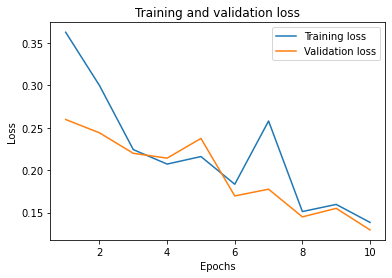

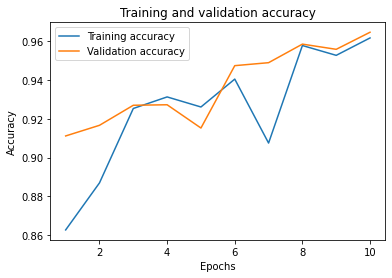

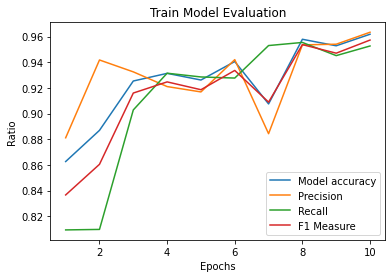

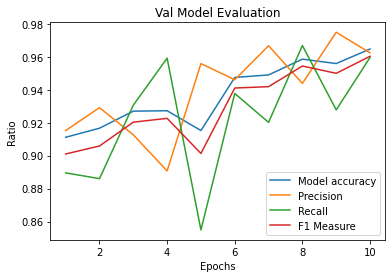

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 6ms/step - loss: 0.1225 - accuracy: 0.9675 - recall_m: 0.9595 - precision_m: 0.9679 - f1_m: 0.9621
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model0/Model-0.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model0/Model-0.json


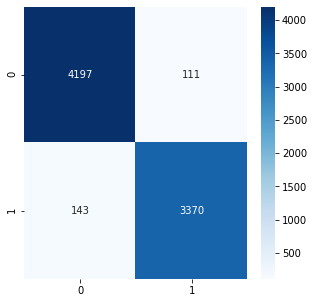

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


In [ ]:
# my_model = TestModel()

In [ ]:
# my_model1 = my_model.loadModelJ('drive/MyDrive/Tugas Akhir/Program/Pickle/Model-0.h5', 'drive/MyDrive/Tugas Akhir/Program/Pickle/Model-0.json')

In [ ]:
# my_model1.evaluate(x_test, y_test)

In [ ]:
# my_model1.predict(x_test)

##### 1 - LSTM: 8

In [ ]:
n = 1
lstm = 8

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 16,826,997
Trainable params: 3,497
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  8
Epoch 1/10
367/367 [==============================] - 8s 18ms/step - loss: 0.3384 - accuracy: 0.8633 - recall_m: 0.8434 - precision_m: 0.8677 - f1_m: 0.8490 - val_loss: 0.2399 - val_accuracy: 0.9032 - val_recall_m: 0.9040 - val_precision_m: 0.8890 - val_f1_m: 0.8947
Epo

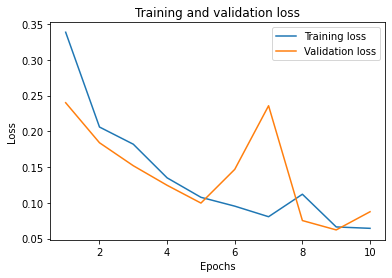

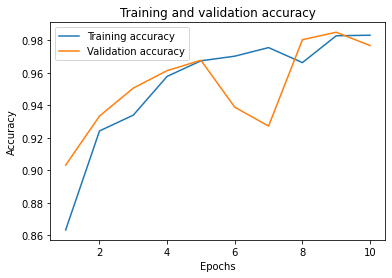

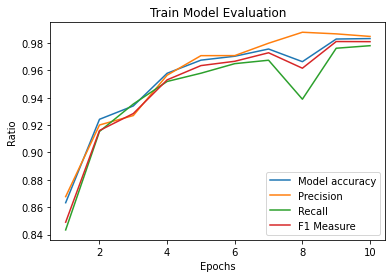

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 8ms/step - loss: 0.0765 - accuracy: 0.9801 - recall_m: 0.9601 - precision_m: 0.9970 - f1_m: 0.9774
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model1/Model-1.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model1/Model-1.json


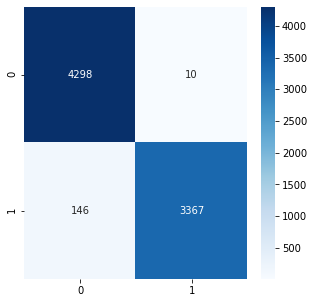

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 2 - LSTM: 16

In [ ]:
n = 2
lstm = 16

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,831,005
Trainable params: 7,505
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  16
Epoch 1/10
367/367 [==============================] - 7s 16ms/step - loss: 0.2968 - accuracy: 0.8786 - recall_m: 0.8458 - precision_m: 0.8883 - f1_m: 0.8585 - val_loss: 0.2021 - val_accuracy: 0.9269 - val_recall_m: 0.9167 - val_precision_m: 0.9254 - val_f1_m: 0.9198
Ep

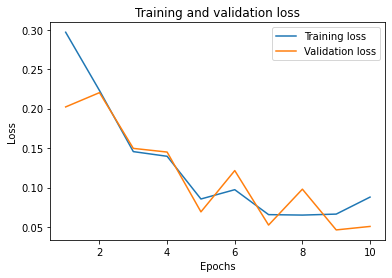

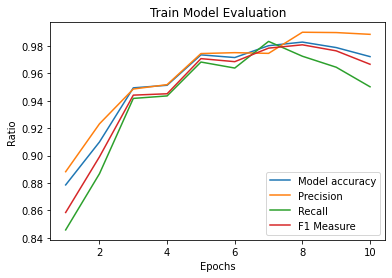

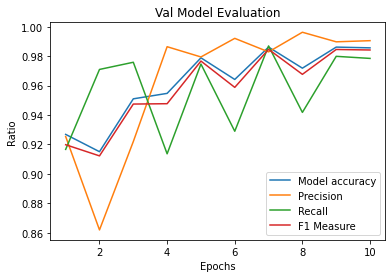

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 6ms/step - loss: 0.0468 - accuracy: 0.9881 - recall_m: 0.9803 - precision_m: 0.9936 - f1_m: 0.9865
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model2/Model-2.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model2/Model-2.json


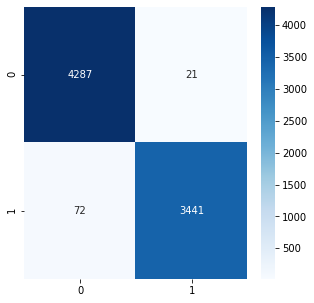

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 3 - LSTM: 32

In [ ]:
n = 3
lstm = 32

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 16,840,557
Trainable params: 17,057
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  32
Epoch 1/10
367/367 [==============================] - 7s 16ms/step - loss: 0.2776 - accuracy: 0.8906 - recall_m: 0.8612 - precision_m: 0.9079 - f1_m: 0.8756 - val_loss: 0.2693 - val_accuracy: 0.8929 - val_recall_m: 0.8650 - val_precision_m: 0.8990 - val_f1_m: 0.8799
E

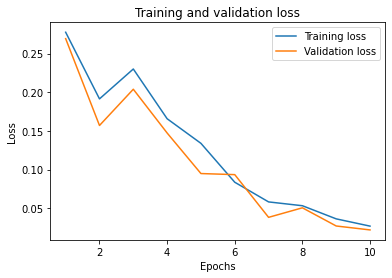

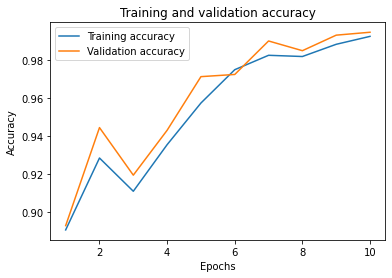

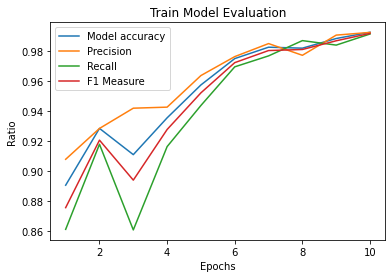

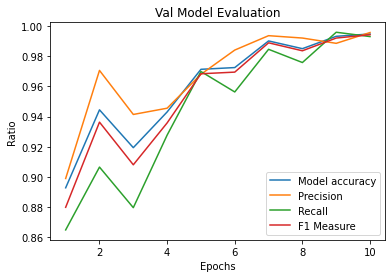

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9927 - recall_m: 0.9916 - precision_m: 0.9933 - f1_m: 0.9922
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model3/Model-3.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model3/Model-3.json


In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 4 - LSTM: 64

In [ ]:
n = 4
lstm = 64

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
367/367 [==============================] - 8s 18ms/step - loss: 0.2888 - accuracy: 0.8847 - recall_m: 0.8324 - precision_m: 0.9157 - f1_m: 0.8631 - val_loss: 0.2512 - val_accuracy: 0.9111 - val_recall_m: 0.9202 - val_precision_m: 0.8897 - val_f1_m: 0.9033
E

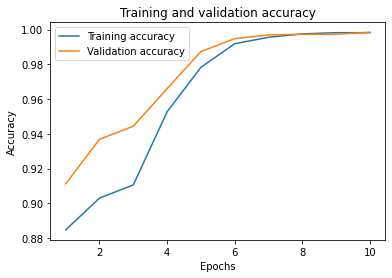

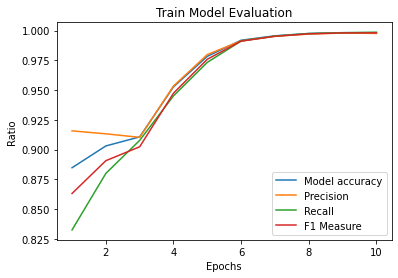

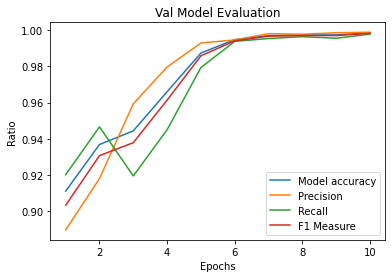

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0072 - accuracy: 0.9981 - recall_m: 0.9984 - precision_m: 0.9976 - f1_m: 0.9979
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model4/Model-4.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model4/Model-4.json


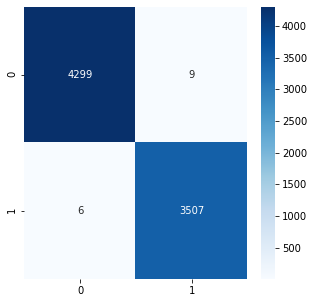

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 5 - LSTM: 128

In [ ]:
n = 5
lstm = 128

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 16,940,877
Trainable params: 117,377
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  128
Epoch 1/10
367/367 [==============================] - 10s 23ms/step - loss: 0.2471 - accuracy: 0.9054 - recall_m: 0.8768 - precision_m: 0.9194 - f1_m: 0.8927 - val_loss: 0.2199 - val_accuracy: 0.9242 - val_recall_m: 0.8773 - val_precision_m: 0.9511 - val_f1_m: 0.911

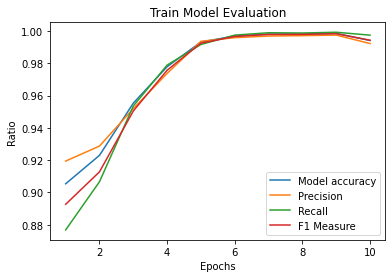

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0100 - accuracy: 0.9980 - recall_m: 0.9985 - precision_m: 0.9973 - f1_m: 0.9978
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model5/Model-5.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model5/Model-5.json


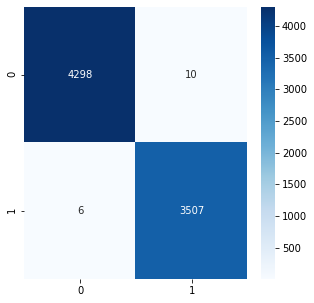

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


#### Pengujian Batch Size

In [ ]:
lstm = 64
batch_sizes = 32

##### 6 - Batch Size: 32

In [ ]:
n = 6

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 13s 16ms/step - loss: 0.4164 - accuracy: 0.8243 - recall_m: 0.7735 - precision_m: 0.8529 - f1_m: 0.7979 - val_loss: 0.3585 - val_accuracy: 0.8507 - val_recall_m: 0.7801 - val_precision_m: 0.8814 - val_f1_m: 0.8232

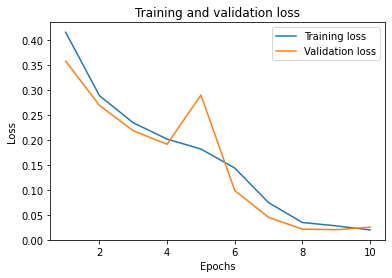

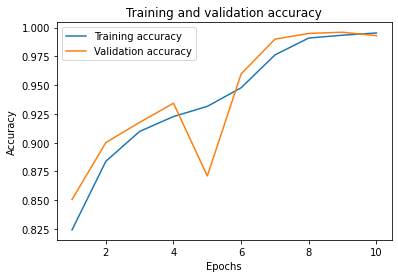

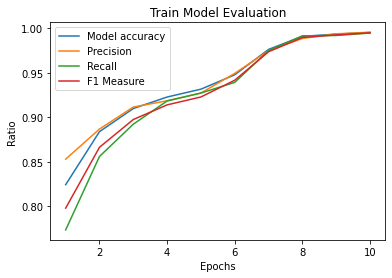

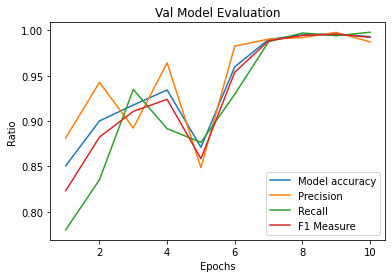

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.9925 - recall_m: 0.9963 - precision_m: 0.9875 - f1_m: 0.9916
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model6/Model-6.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model6/Model-6.json


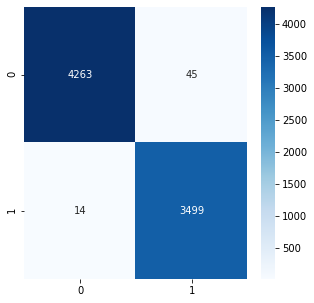

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 7 - Batch Size: 64

In [ ]:
n = 7
batch_sizes = 64

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
367/367 [==============================] - 8s 18ms/step - loss: 0.2974 - accuracy: 0.8797 - recall_m: 0.8375 - precision_m: 0.8990 - f1_m: 0.8566 - val_loss: 0.2590 - val_accuracy: 0.8995 - val_recall_m: 0.8503 - val_precision_m: 0.9256 - val_f1_m: 0.8847


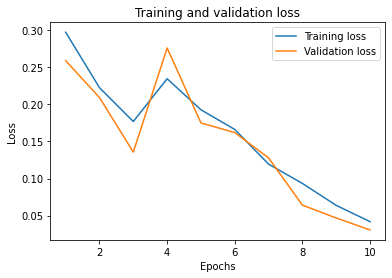

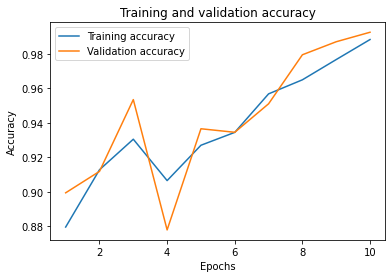

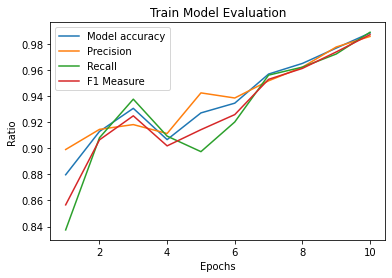

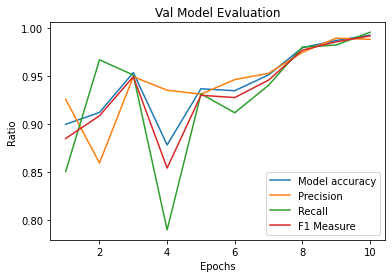

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0336 - accuracy: 0.9910 - recall_m: 0.9938 - precision_m: 0.9871 - f1_m: 0.9901
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model7/Model-7.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model7/Model-7.json


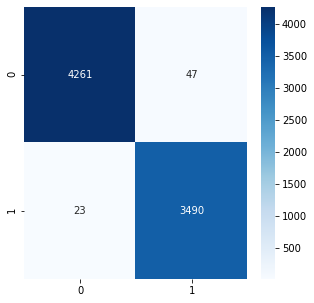

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 8 - Batch Size: 128

In [ ]:
n = 8
batch_sizes = 128

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
184/184 [==============================] - 6s 25ms/step - loss: 0.2711 - accuracy: 0.8961 - recall_m: 0.8782 - precision_m: 0.8983 - f1_m: 0.8827 - val_loss: 0.4826 - val_accuracy: 0.7379 - val_recall_m: 0.9949 - val_precision_m: 0.6397 - val_f1_m: 0.7774


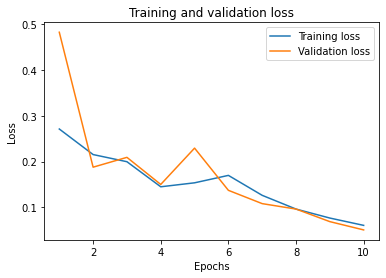

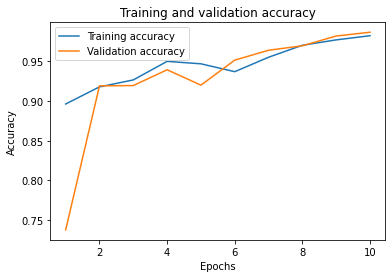

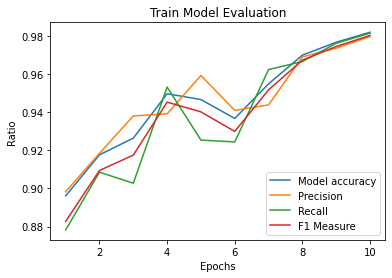

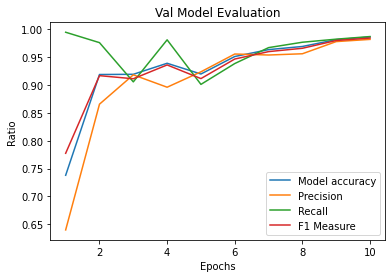

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0478 - accuracy: 0.9862 - recall_m: 0.9896 - precision_m: 0.9784 - f1_m: 0.9834
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model8/Model-8.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model8/Model-8.json


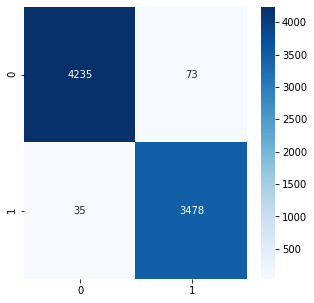

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 9 - Batch Size: 256

In [ ]:
n = 9
batch_sizes = 256

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
92/92 [==============================] - 5s 35ms/step - loss: 0.3298 - accuracy: 0.8633 - recall_m: 0.7997 - precision_m: 0.9149 - f1_m: 0.8413 - val_loss: 0.2515 - val_accuracy: 0.9077 - val_recall_m: 0.8904 - val_precision_m: 0.9064 - val_f1_m: 0.8980
Ep

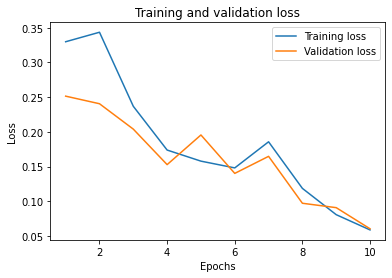

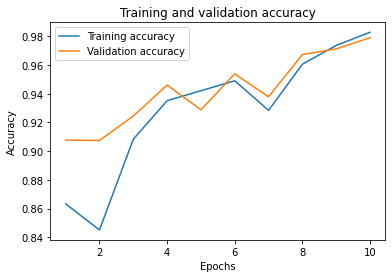

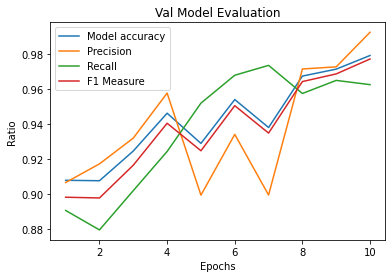

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0536 - accuracy: 0.9836 - recall_m: 0.9690 - precision_m: 0.9949 - f1_m: 0.9811
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model9/Model-9.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model9/Model-9.json


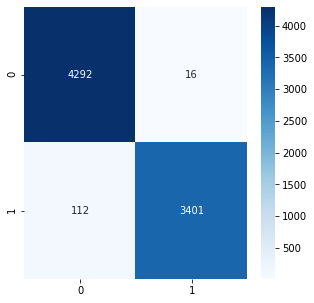

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


#### Pengujian Learning Rate dan Epoch

In [ ]:
lstm = 64
batch_sizes = 32

##### Lr = 0.01

In [ ]:
lr = 0.01

###### Epoch 10

In [ ]:
epochs = 10

###### 10 - lr: 0.01 e: 10

In [ ]:
n = 10

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.01
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 13s 16ms/step - loss: 0.1341 - accuracy: 0.9445 - recall_m: 0.9316 - precision_m: 0.9459 - f1_m: 0.9331 - val_loss: 0.4232 - val_accuracy: 0.8058 - val_recall_m: 0.7665 - val_precision_m: 0.8024 - val_f1_m: 0.7780


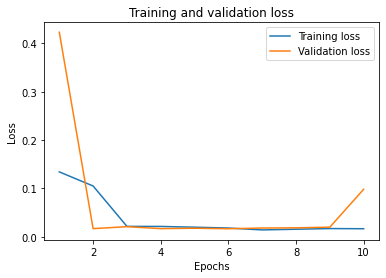

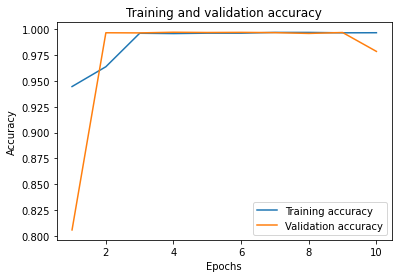

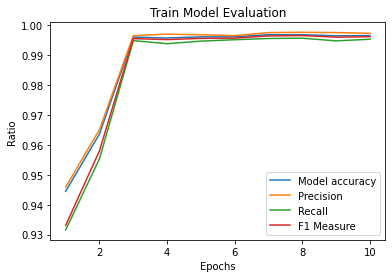

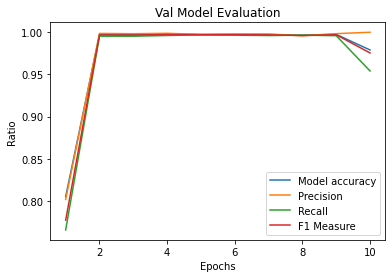

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0887 - accuracy: 0.9813 - recall_m: 0.9612 - precision_m: 0.9978 - f1_m: 0.9785
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model10/Model-10.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model10/Model-10.json


In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 20

In [ ]:
epochs = 20

###### 11 - lr: 0.01 e: 20

In [ ]:
n = 11

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  20
Adam Learning Rate set to :  0.01
LSTM neuron set to        :  64
Epoch 1/20
734/734 [==============================] - 14s 16ms/step - loss: 0.1062 - accuracy: 0.9607 - recall_m: 0.9487 - precision_m: 0.9658 - f1_m: 0.9544 - val_loss: 0.0276 - val_accuracy: 0.9951 - val_recall_m: 0.9950 - val_precision_m: 0.9946 - val_f1_m: 0.9947


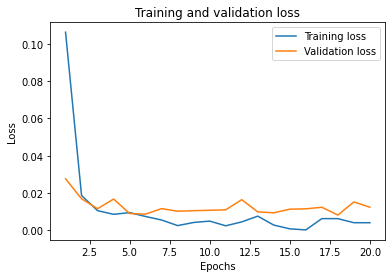

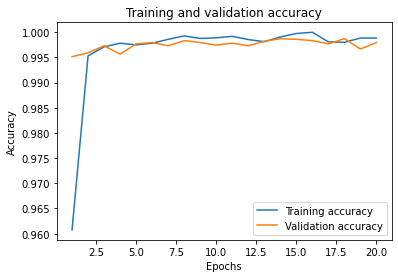

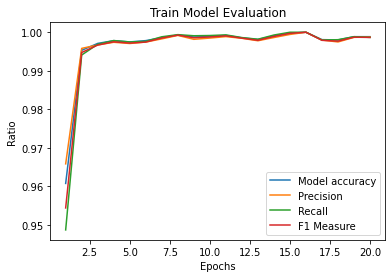

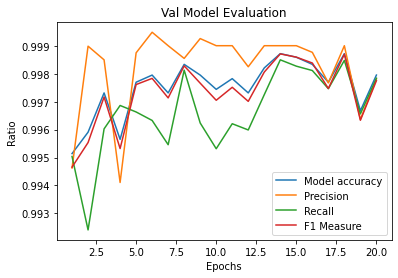

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0210 - accuracy: 0.9967 - recall_m: 0.9977 - precision_m: 0.9954 - f1_m: 0.9964
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model11/Model-11.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model11/Model-11.json


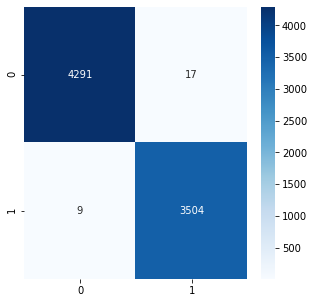

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 50

In [ ]:
epochs = 50

###### 12 - lr: 0.01 e: 50

In [ ]:
n = 12

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  50
Adam Learning Rate set to :  0.01
LSTM neuron set to        :  64
Epoch 1/50
734/734 [==============================] - 13s 16ms/step - loss: 0.1511 - accuracy: 0.9420 - recall_m: 0.9289 - precision_m: 0.9484 - f1_m: 0.9334 - val_loss: 0.0186 - val_accuracy: 0.9957 - val_recall_m: 0.9924 - val_precision_m: 0.9982 - val_f1_m: 0.9952


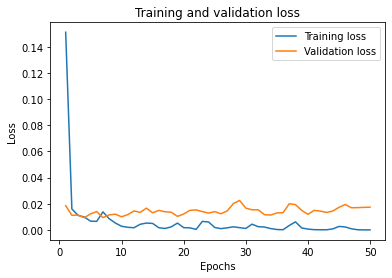

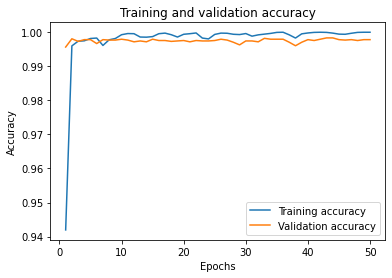

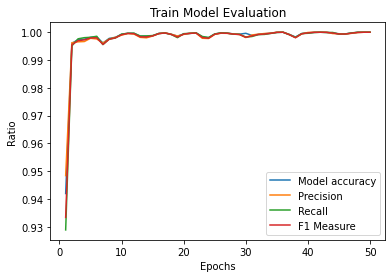

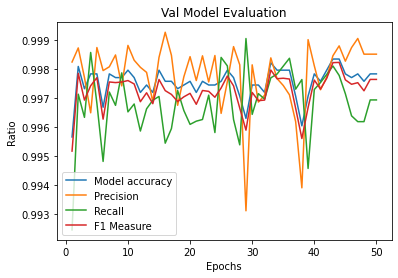

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0188 - accuracy: 0.9976 - recall_m: 0.9988 - precision_m: 0.9965 - f1_m: 0.9975
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model12/Model-12.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model12/Model-12.json


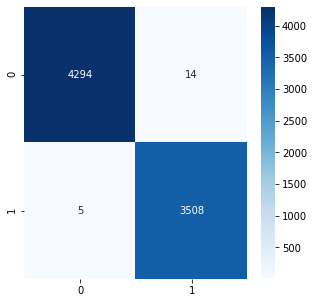

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 100

In [ ]:
epochs = 100

###### 13 - lr: 0.01 e: 100

In [ ]:
n = 13

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  100
Adam Learning Rate set to :  0.01
LSTM neuron set to        :  64
Epoch 1/100
734/734 [==============================] - 13s 16ms/step - loss: 0.1187 - accuracy: 0.9564 - recall_m: 0.9448 - precision_m: 0.9626 - f1_m: 0.9506 - val_loss: 0.0133 - val_accuracy: 0.9964 - val_recall_m: 0.9959 - val_precision_m: 0.9968 - val_f1_m: 0.996

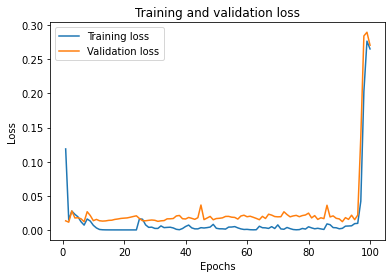

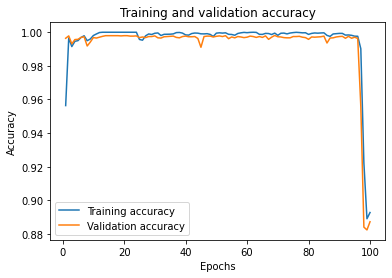

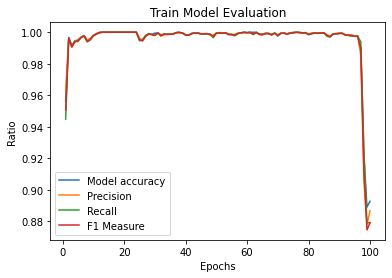

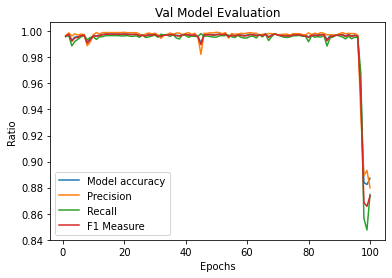

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.2638 - accuracy: 0.8876 - recall_m: 0.8795 - precision_m: 0.8723 - f1_m: 0.8713
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model13/Model-13.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model13/Model-13.json


In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### Lr = 0.001

In [ ]:
lr = 0.001

###### Epoch 10

In [ ]:
epochs = 10

###### 14 - lr: 0.001 e: 10

In [ ]:
n = 14

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 13s 16ms/step - loss: 0.2692 - accuracy: 0.8909 - recall_m: 0.8577 - precision_m: 0.8993 - f1_m: 0.8664 - val_loss: 0.2133 - val_accuracy: 0.9155 - val_recall_m: 0.8422 - val_precision_m: 0.9711 - val_f1_m: 0.8990

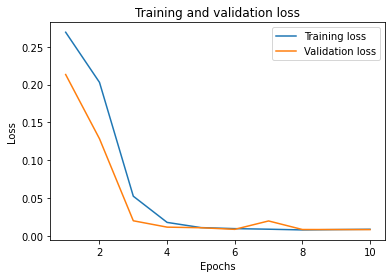

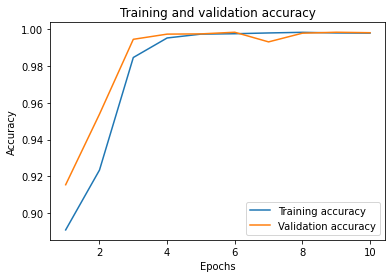

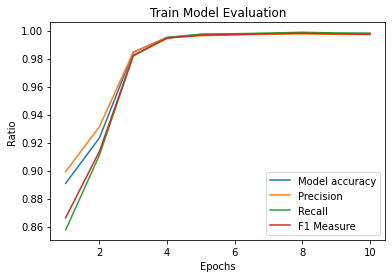

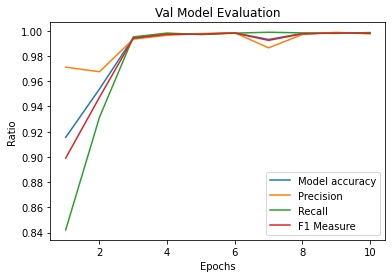

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0114 - accuracy: 0.9977 - recall_m: 0.9989 - precision_m: 0.9964 - f1_m: 0.9976
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model14/Model-14.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model14/Model-14.json


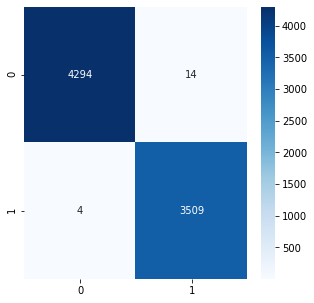

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 20

In [ ]:
epochs = 20

###### 15 - lr: 0.001 e: 20

In [ ]:
n = 15

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  20
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/20
734/734 [==============================] - 13s 16ms/step - loss: 0.2740 - accuracy: 0.8891 - recall_m: 0.8589 - precision_m: 0.9052 - f1_m: 0.8706 - val_loss: 0.3253 - val_accuracy: 0.8693 - val_recall_m: 0.8369 - val_precision_m: 0.8744 - val_f1_m: 0.8512

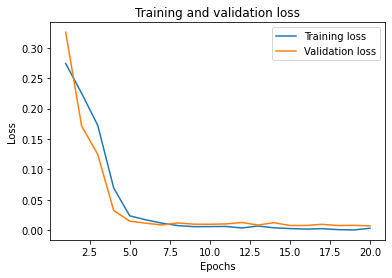

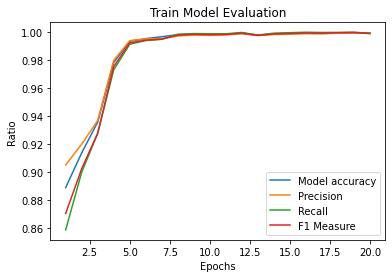

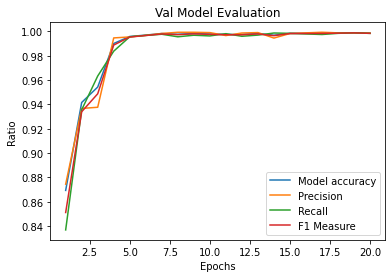

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0108 - accuracy: 0.9980 - recall_m: 0.9982 - precision_m: 0.9977 - f1_m: 0.9979
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model15/Model-15.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model15/Model-15.json


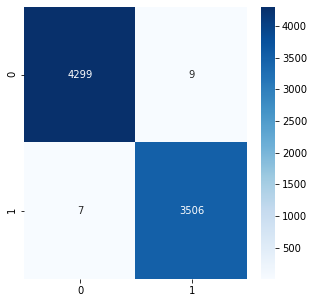

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 50

In [ ]:
epochs = 50

###### 16 - lr: 0.001 e: 50

In [ ]:
n = 16

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  50
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/50
734/734 [==============================] - 13s 16ms/step - loss: 0.2675 - accuracy: 0.8920 - recall_m: 0.8579 - precision_m: 0.9122 - f1_m: 0.8726 - val_loss: 0.2840 - val_accuracy: 0.8819 - val_recall_m: 0.7999 - val_precision_m: 0.9352 - val_f1_m: 0.8579

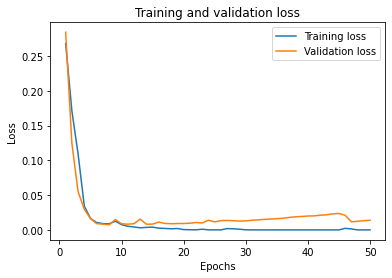

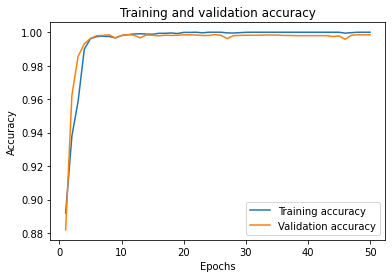

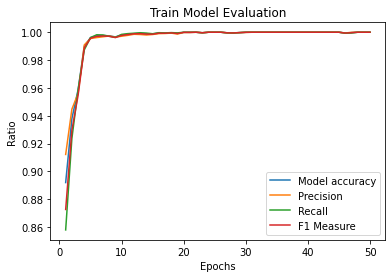

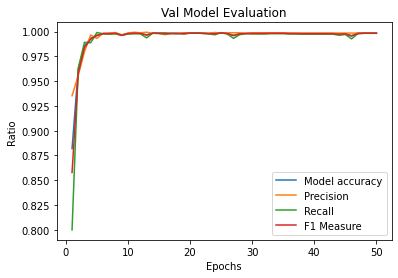

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0088 - accuracy: 0.9986 - recall_m: 0.9997 - precision_m: 0.9974 - f1_m: 0.9985
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model16/Model-16.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model16/Model-16.json


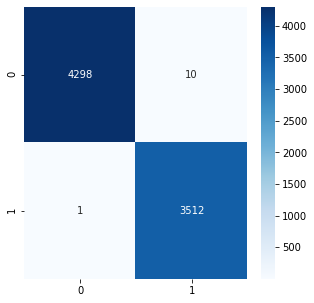

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 100

In [ ]:
epochs = 100

###### 17 - lr: 0.001 e: 100

In [ ]:
n = 17

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  100
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/100
734/734 [==============================] - 13s 16ms/step - loss: 0.2413 - accuracy: 0.9072 - recall_m: 0.8846 - precision_m: 0.9152 - f1_m: 0.8917 - val_loss: 0.1705 - val_accuracy: 0.9372 - val_recall_m: 0.9279 - val_precision_m: 0.9363 - val_f1_m: 0.93

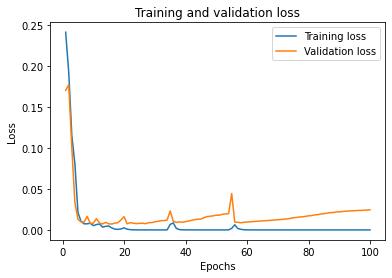

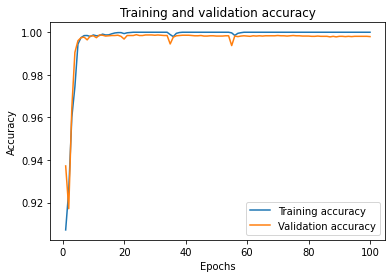

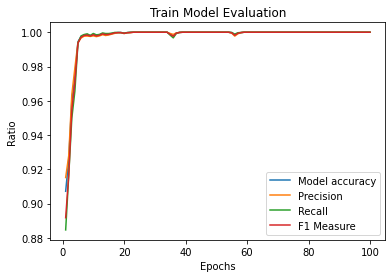

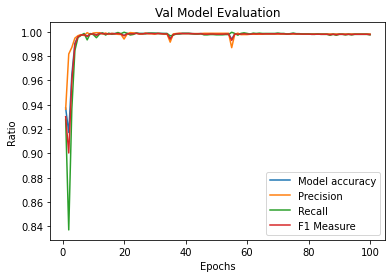

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0214 - accuracy: 0.9981 - recall_m: 0.9985 - precision_m: 0.9975 - f1_m: 0.9980
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model17/Model-17.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model17/Model-17.json


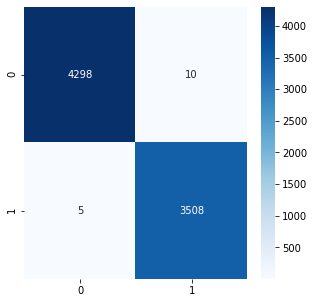

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### Lr = 0.0001

In [ ]:
lr = 0.0001

###### Epoch 10

In [ ]:
epochs = 10

###### 18 - lr: 0.0001 e: 10

In [ ]:
n = 18

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.0001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 13s 16ms/step - loss: 0.3308 - accuracy: 0.8627 - recall_m: 0.8291 - precision_m: 0.8733 - f1_m: 0.8318 - val_loss: 0.2276 - val_accuracy: 0.9201 - val_recall_m: 0.9212 - val_precision_m: 0.9078 - val_f1_m: 0.911

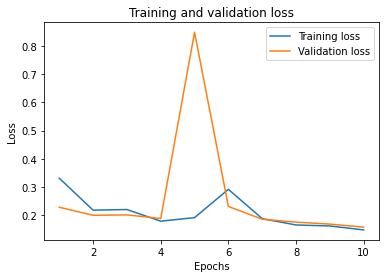

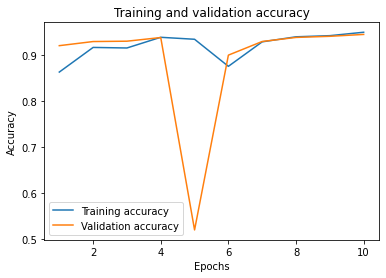

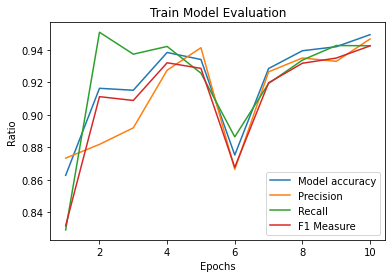

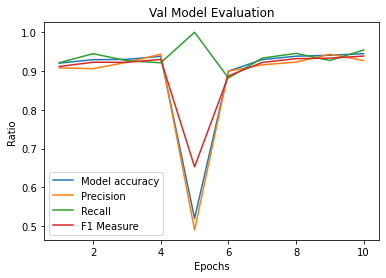

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.1498 - accuracy: 0.9460 - recall_m: 0.9542 - precision_m: 0.9275 - f1_m: 0.9381
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model18/Model-18.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model18/Model-18.json


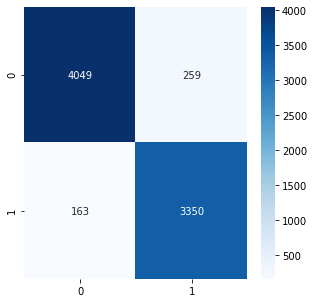

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 20

In [ ]:
epochs = 20

###### 19 - lr: 0.0001 e: 20

In [ ]:
n = 19

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  20
Adam Learning Rate set to :  0.0001
LSTM neuron set to        :  64
Epoch 1/20
734/734 [==============================] - 13s 16ms/step - loss: 0.3183 - accuracy: 0.8760 - recall_m: 0.8266 - precision_m: 0.8980 - f1_m: 0.8439 - val_loss: 0.2374 - val_accuracy: 0.9119 - val_recall_m: 0.9465 - val_precision_m: 0.8730 - val_f1_m: 0.905

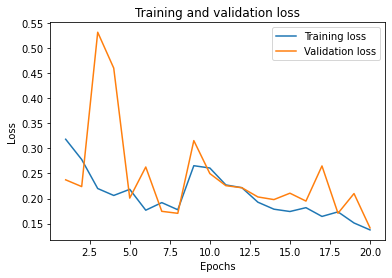

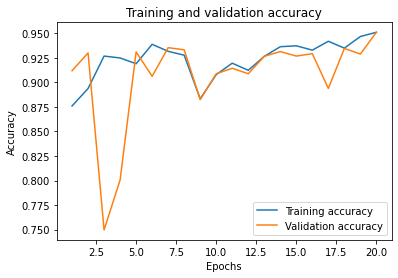

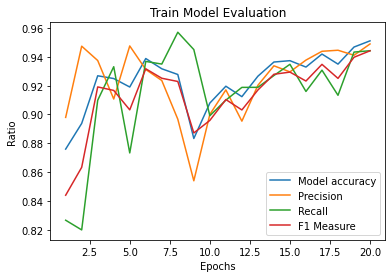

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.1371 - accuracy: 0.9503 - recall_m: 0.9474 - precision_m: 0.9411 - f1_m: 0.9417
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model19/Model-19.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model19/Model-19.json


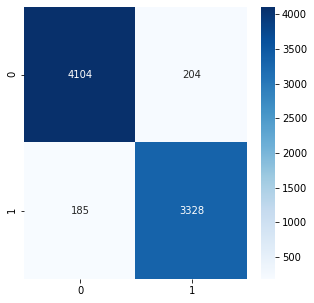

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 50

In [ ]:
epochs = 50

###### 20 - lr: 0.0001 e: 50

In [ ]:
n = 20

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  50
Adam Learning Rate set to :  0.0001
LSTM neuron set to        :  64
Epoch 1/50
734/734 [==============================] - 13s 16ms/step - loss: 0.3314 - accuracy: 0.8754 - recall_m: 0.8154 - precision_m: 0.9139 - f1_m: 0.8510 - val_loss: 0.3171 - val_accuracy: 0.8703 - val_recall_m: 0.7529 - val_precision_m: 0.9581 - val_f1_m: 0.838

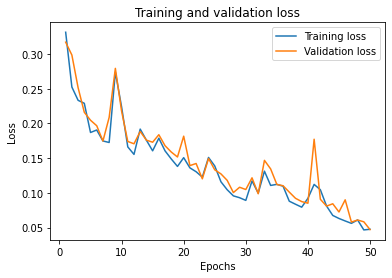

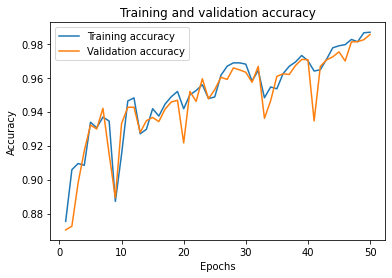

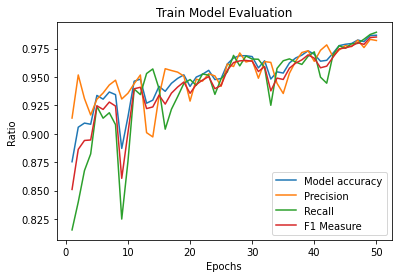

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0437 - accuracy: 0.9882 - recall_m: 0.9896 - precision_m: 0.9843 - f1_m: 0.9864
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model20/Model-20.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model20/Model-20.json


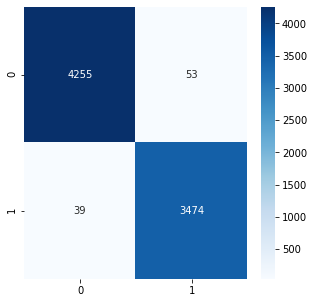

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


###### Epoch 100

In [ ]:
epochs = 100

###### 21 - lr: 0.0001 e: 100

In [ ]:
n = 21

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 300, 100)          16823500  
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  100
Adam Learning Rate set to :  0.0001
LSTM neuron set to        :  64
Epoch 1/100
734/734 [==============================] - 13s 16ms/step - loss: 0.3309 - accuracy: 0.8660 - recall_m: 0.8638 - precision_m: 0.8657 - f1_m: 0.8510 - val_loss: 0.2244 - val_accuracy: 0.9179 - val_recall_m: 0.9293 - val_precision_m: 0.8963 - val_f1_m: 0.9

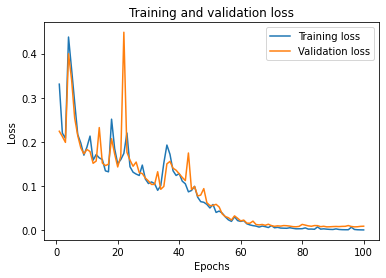

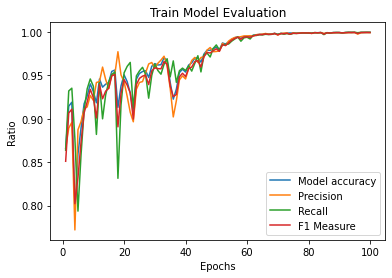

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 7ms/step - loss: 0.0105 - accuracy: 0.9980 - recall_m: 0.9986 - precision_m: 0.9971 - f1_m: 0.9978
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model21/Model-21.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model21/Model-21.json


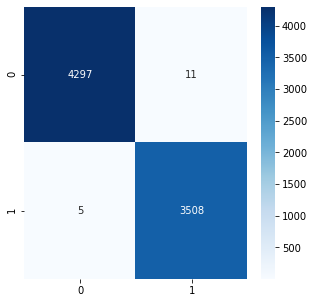

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


#### Pengujian Sequence Length

In [ ]:
lstm = 64
batch_sizes = 32
epochs = 10
lr = 0.001

##### 22 - Sequence Len: 150

In [ ]:
pad_shape = 150

x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_150')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_150')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_150')

In [ ]:
n = 22

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          16823500  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 15s 12ms/step - loss: 0.3443 - accuracy: 0.8614 - recall_m: 0.8216 - precision_m: 0.8713 - f1_m: 0.8323 - val_loss: 0.3125 - val_accuracy: 0.8578 - val_recall_m: 0.7355 - val_precision_m: 0.9456 - val_f1_m: 0.8225
Ep

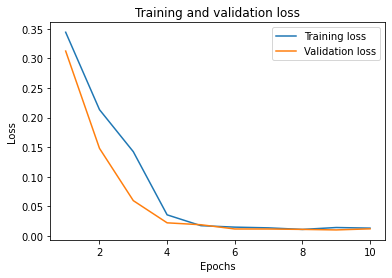

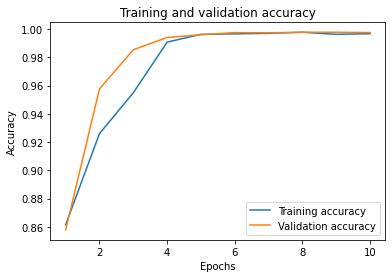

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 1s 6ms/step - loss: 0.0127 - accuracy: 0.9976 - recall_m: 0.9993 - precision_m: 0.9958 - f1_m: 0.9975
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model22/Model-22.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model22/Model-22.json


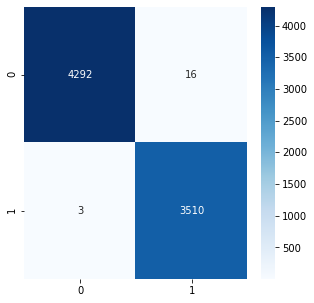

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 23 - Sequence Len: 300

In [ ]:
pad_shape = 300

x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_300')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_300')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_300')

In [ ]:
n = 23

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          16823500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 16s 19ms/step - loss: 0.2599 - accuracy: 0.8960 - recall_m: 0.8584 - precision_m: 0.9148 - f1_m: 0.8763 - val_loss: 0.4085 - val_accuracy: 0.8711 - val_recall_m: 0.7337 - val_precision_m: 0.9824 - val_f1_m: 0.8353


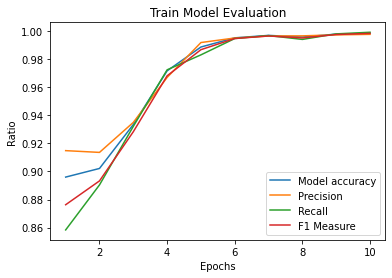

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 2s 9ms/step - loss: 0.0090 - accuracy: 0.9973 - recall_m: 0.9967 - precision_m: 0.9976 - f1_m: 0.9971
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model23/Model-23.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model23/Model-23.json


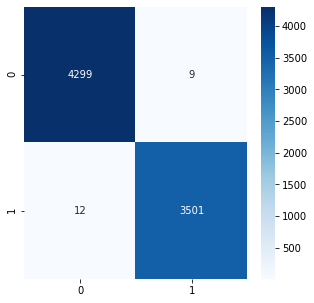

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 24 - Sequence Len: 450

In [ ]:
pad_shape = 450

x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_450')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_450')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_450')

In [ ]:
n = 24

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 450, 100)          16823500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 22s 27ms/step - loss: 0.1903 - accuracy: 0.9268 - recall_m: 0.9100 - precision_m: 0.9358 - f1_m: 0.9169 - val_loss: 0.1739 - val_accuracy: 0.9404 - val_recall_m: 0.8939 - val_precision_m: 0.9752 - val_f1_m: 0.9306


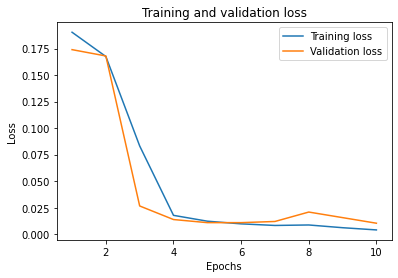

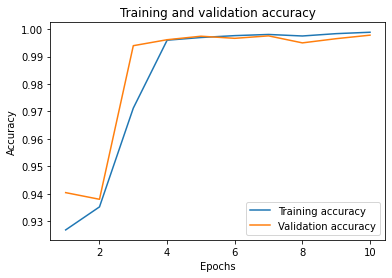

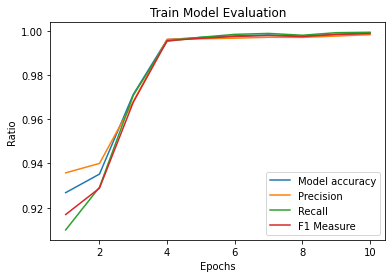

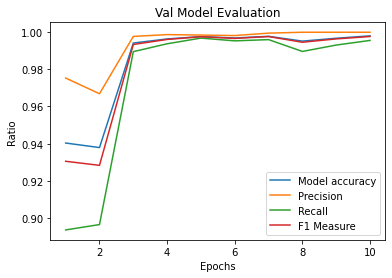

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 3s 12ms/step - loss: 0.0094 - accuracy: 0.9976 - recall_m: 0.9982 - precision_m: 0.9969 - f1_m: 0.9974
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model24/Model-24.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model24/Model-24.json


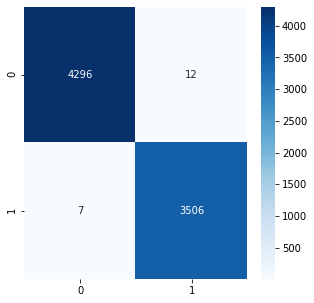

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 25 - Sequence Len: 600

In [ ]:
pad_shape = 600

x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_600')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_600')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_600')

In [ ]:
n = 25

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 100)          16823500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 27s 34ms/step - loss: 0.1899 - accuracy: 0.9229 - recall_m: 0.9086 - precision_m: 0.9248 - f1_m: 0.9104 - val_loss: 0.2079 - val_accuracy: 0.9206 - val_recall_m: 0.8444 - val_precision_m: 0.9815 - val_f1_m: 0.9051


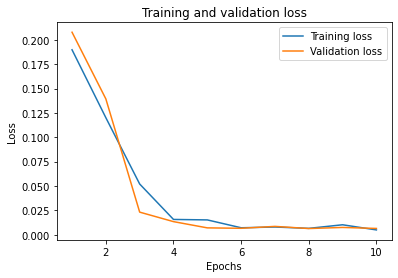

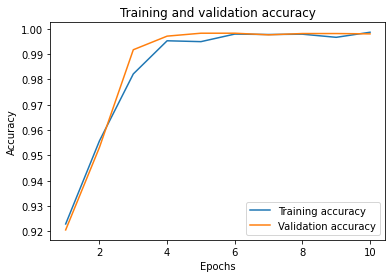

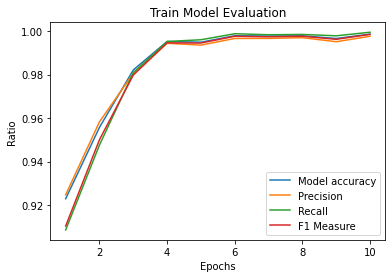

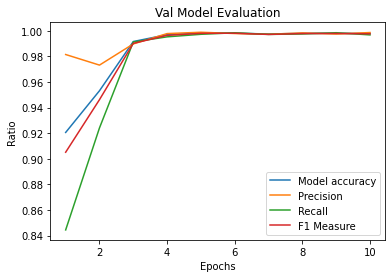

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 4s 15ms/step - loss: 0.0070 - accuracy: 0.9980 - recall_m: 0.9987 - precision_m: 0.9970 - f1_m: 0.9978
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model25/Model-25.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model25/Model-25.json


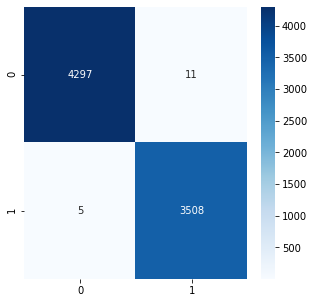

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


#### Pengujian Panjang Kata Minimal!

##### 26 - Panjang Kata Min: 0

In [ ]:
n = 26

In [ ]:
lstm = 64
batch_sizes = 32
epochs = 10
lr = 0.001

pad_shape = 150



embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/glove_100d')

In [ ]:
x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_150')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_150')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_150')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_test')

word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/word_index')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 100)          16823500  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,865,805
Trainable params: 42,305
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 9s 10ms/step - loss: 0.3455 - accuracy: 0.8620 - recall_m: 0.8353 - precision_m: 0.8741 - f1_m: 0.8363 - val_loss: 0.2176 - val_accuracy: 0.9252 - val_recall_m: 0.9140 - val_precision_m: 0.9250 - val_f1_m: 0.9170
E

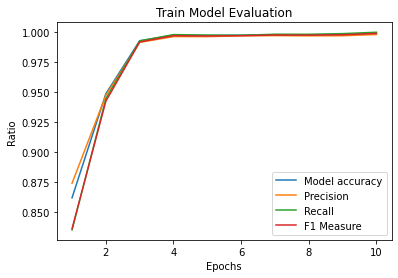

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.9985 - recall_m: 1.0000 - precision_m: 0.9968 - f1_m: 0.9983
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model26/Model-26.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model26/Model-26.json


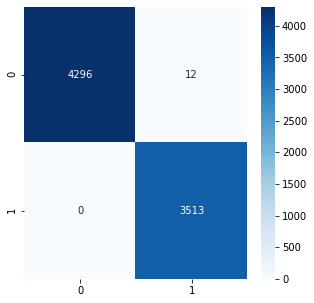

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 27 - Panjang Kata Min: 25

In [ ]:
n = 27

In [ ]:




embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/glove_100d')

In [ ]:
x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/x_train_150')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/x_val_150')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/x_test_150')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/y_test')

word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_25/word_index')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 100)          16811500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 16,853,805
Trainable params: 42,305
Non-trainable params: 16,811,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
715/715 [==============================] - 8s 9ms/step - loss: 0.3138 - accuracy: 0.8748 - recall_m: 0.8389 - precision_m: 0.8769 - f1_m: 0.8453 - val_loss: 0.2678 - val_accuracy: 0.8886 - val_recall_m: 0.8173 - val_precision_m: 0.9287 - val_f1_m: 0.8645
Ep

------------------EVALUATE MODEL--------------------
239/239 [==============================] - 1s 4ms/step - loss: 0.0113 - accuracy: 0.9976 - recall_m: 0.9968 - precision_m: 0.9977 - f1_m: 0.9972
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model27/Model-27.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model27/Model-27.json


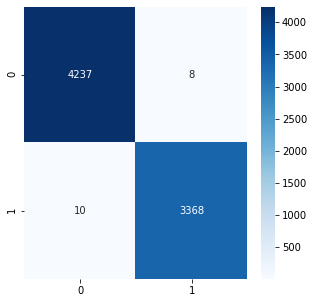

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 28 - Panjang Kata Min: 50

In [ ]:
n = 28

In [ ]:




embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/glove_100d')

In [ ]:
x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/x_train_150')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/x_val_150')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/x_test_150')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/y_test')

word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_50/word_index')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 100)          16852800  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 16,895,105
Trainable params: 42,305
Non-trainable params: 16,852,800
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
682/682 [==============================] - 9s 10ms/step - loss: 0.3660 - accuracy: 0.8510 - recall_m: 0.7982 - precision_m: 0.8756 - f1_m: 0.8135 - val_loss: 0.3378 - val_accuracy: 0.8624 - val_recall_m: 0.7932 - val_precision_m: 0.8905 - val_f1_m: 0.8332
E

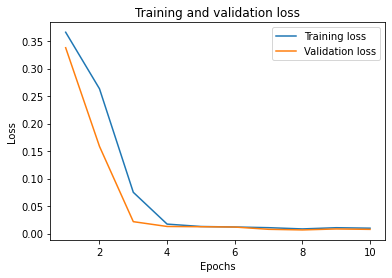

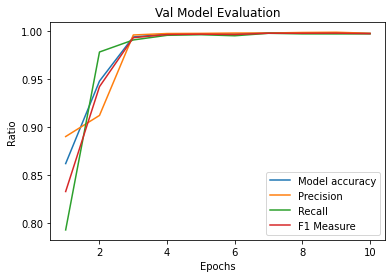

------------------EVALUATE MODEL--------------------
228/228 [==============================] - 1s 4ms/step - loss: 0.0103 - accuracy: 0.9977 - recall_m: 0.9978 - precision_m: 0.9972 - f1_m: 0.9974
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model28/Model-28.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model28/Model-28.json


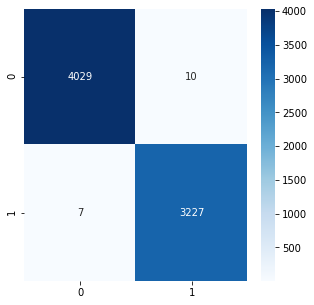

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


##### 29 - Panjang Kata Min: 100

In [ ]:
n = 29

In [ ]:




embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/glove_100d')

In [ ]:
x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/x_train_150')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/x_val_150')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/x_test_150')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/y_test')

word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_100/word_index')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 100)          16447700  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,490,005
Trainable params: 42,305
Non-trainable params: 16,447,700
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
LSTM neuron set to        :  64
Epoch 1/10
586/586 [==============================] - 7s 10ms/step - loss: 0.4112 - accuracy: 0.8307 - recall_m: 0.8074 - precision_m: 0.8466 - f1_m: 0.8066 - val_loss: 0.5798 - val_accuracy: 0.7632 - val_recall_m: 0.5404 - val_precision_m: 0.9815 - val_f1_m: 0.6885
E

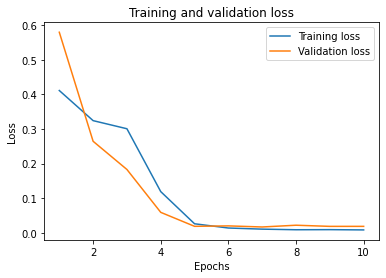

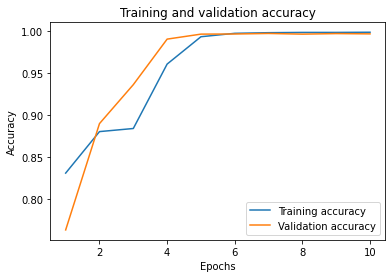

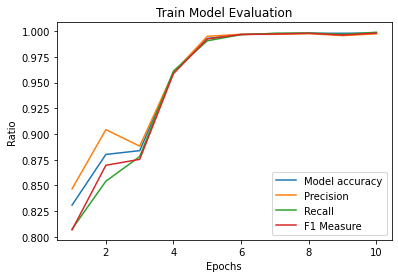

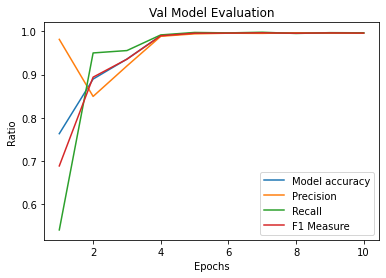

------------------EVALUATE MODEL--------------------
196/196 [==============================] - 1s 4ms/step - loss: 0.0253 - accuracy: 0.9955 - recall_m: 0.9904 - precision_m: 0.9902 - f1_m: 0.9901
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model29/Model-29.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur1/Model29/Model-29.json


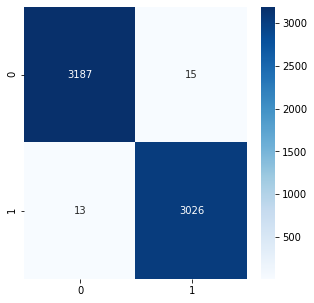

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 1)
model_build[n].lstm(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


#### GRU!

In [ ]:
n = 30
lstm = 64
batch_sizes = 32
epochs = 10
lr = 0.001
dense = 0
pad_shape = 600



embedding_matrix = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/glove_100d')

In [ ]:
x_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_train_600')
x_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_val_600')
x_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/x_test_600')

y_train = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_train')
y_val = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_val')
y_test = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/y_test')

word_index = my_pickle.pickleLoad('drive/MyDrive/Tugas Akhir/Program/Pickle/isot/data_0/word_index')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 600, 100)          16823500  
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                31872     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 16,855,437
Trainable params: 31,937
Non-trainable params: 16,823,500
_________________________________________________________________
Epoch set to              :  10
Adam Learning Rate set to :  0.001
GRU neuron set to        :  64
Epoch 1/10
734/734 [==============================] - 20s 25ms/step - loss: 0.1444 - accuracy: 0.9442 - recall_m: 0.9259 - precision_m: 0.9481 - f1_m: 0.9330 - val_loss: 0.0221 - val_accuracy: 0.9944 - val_recall_m: 0.9901 - val_precision_m: 0.9976 - val_f1_m: 0.9936


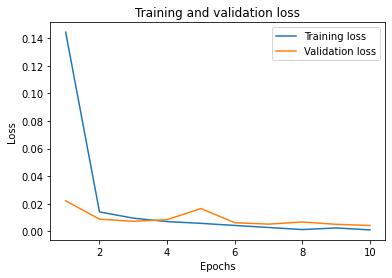

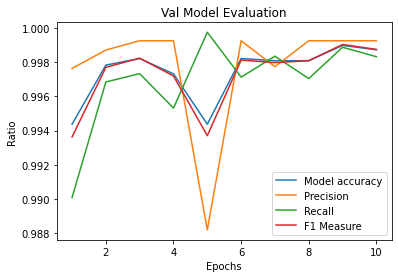

------------------EVALUATE MODEL--------------------
245/245 [==============================] - 3s 11ms/step - loss: 0.0063 - accuracy: 0.9983 - recall_m: 0.9994 - precision_m: 0.9971 - f1_m: 0.9982
----------------------------------------------------
Model Path Saved:
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur3/Model30/Model-30.h5
drive/MyDrive/Tugas Akhir/Program/Pickle/isot_model/arsitektur3/Model30/Model-30.json


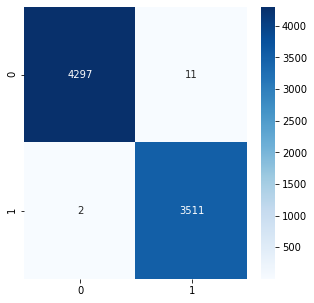

In [ ]:
model_build[n] = Model(lstm_neuron=lstm,
                     dense_neuron=dense,
                     learning_rate=lr,
                     epoch=epochs,
                     batch_size=batch_sizes,
                     arsitektur = 3)
model_build[n].gru(word_index, embedding_matrix, pad_shape)
model_build[n].summary()
history[n], model[n] = model_build[n].doTrain(x_train,y_train,x_val,y_val)
model_build[n].lossSummary(history[n])
model_build[n].accSummary(history[n])
model_build[n].modelTrainEvaluation(history[n])
model_build[n].modelValEvaluation(history[n])
model_build[n].doPredict(x_test, y_test)
model_build[n].saveModel(n)


In [ ]:
print(2**3)

8
